# <u><center>Project 2 Part 6 Core
- Authored by: Eric N. Valdez
- Date: 4/12/2024

## <u>Instructions
For this part of the project, you will be using machine learning and deep NLP to classify the reviews.

# Imports:

In [1]:
# From source: https://keras.io/examples/keras_recipes/reproducibility_recipes/
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()
# Source: https://discuss.tensorflow.org/t/upgrading-os-to-sonoma-on-my-mac-causing-tensorflow-errors/19846/5
tf.config.set_visible_devices([], 'GPU')

In [2]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [3]:
import joblib
%load_ext autoreload
%autoreload 2
import movie_functions as fn

In [4]:
%reload_ext autoreload

# Load and Clean Data
- Use the original review column as your X and the classification target (High/Low Rating Reviews) as your y:

In [5]:
# loading the joblib from part 5 of the project
df = joblib.load('Data-NLP/processed_data.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8650 entries, 843 to 575264
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_title  8650 non-null   object 
 1   review          8650 non-null   object 
 2   rating          7454 non-null   float64
 3   ratings         2419 non-null   object 
 4   tokens          8650 non-null   object 
 5   lemmatized      8650 non-null   object 
 6   tokens-joined   8650 non-null   object 
 7   lemmas-joined   8650 non-null   object 
dtypes: float64(1), object(7)
memory usage: 608.2+ KB


,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
843,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...","[fine, piece, cinema, wong, kar, wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end, long, friendship, develop, usually, noodle, en...",fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...,fine piece cinema wong kar wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usually noodle entirely platonic relationship solid tru...
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
7443,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0,None,"[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, ★, ★, ★, like, personally, recommend]",roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating ★ ★ ★ like personally recommend
7443,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, producti

In [6]:
def create_groups(x):
    if x>=5.0:
        return "None"
    elif x <=9.0:
        return "None"
    elif x >=9.0: 
        return "High"
    elif x<=4.0:
        return "Low"

In [7]:
# Use the function to create a new "rating" column with groups
df['no_rating'] = df['rating'].map(create_groups)
df['no_rating'].value_counts(dropna=False)

None    7454
None    1196
Name: no_rating, dtype: int64

In [8]:
## Check class balance of 'rating'
df['ratings'].value_counts(normalize=True)

Low_rating     0.505994
High_rating    0.494006
Name: ratings, dtype: float64

In [9]:
# Create a df_ml without null ratings
df = df.dropna(subset=['ratings']).copy()
df.isna().sum()

original_title    0
review            0
rating            0
ratings           0
tokens            0
lemmatized        0
tokens-joined     0
lemmas-joined     0
no_rating         0
dtype: int64

In [10]:
df.head()

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined,no_rating
movie_id,,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,None
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,None
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide pus

In [11]:
# Drop a column
df.drop(columns=['no_rating'], inplace=True)
df.head()

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well h

In [12]:
# # Define X and y
X = df['review']
y = df['ratings']

X.head()

movie_id
7443                                                    A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.
955     The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...
955     After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....
2621    Okay, I will admit I can be a bit of an easy grader when it

In [13]:
y.value_counts(normalize=True)

Low_rating     0.505994
High_rating    0.494006
Name: ratings, dtype: float64

# Machine Learning:
- For this project, you will use modeling pipelines with the text vectorizer and model in the same pipeline.
- This will make saving and uploading the models in a deployed application very easy.

## `Create a Text Vectorizer`
- Select a sklearn vectorizer for your task.
    - Remember to consider your preprocessing choices, such as using stopwords, ngram_range, etc.

In [14]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df['review']

# y - use our binary target 
y = df['ratings']
X.head(10)

movie_id
7443                                                     A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.
955      The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...
955      After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....
2621     Okay, I will admit I can be a bit of an easy grader whe

In [15]:
y.value_counts(normalize=True)

Low_rating     0.505994
High_rating    0.494006
Name: ratings, dtype: float64

In [16]:
# Split data into train, test, val
X_train_full, X_test, y_train_full, y_test = fn.train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = fn.train_test_split(X_test, y_test, test_size=.5, random_state=42)
(len(X_train_full), len(X_val), len(X_test))

(1693, 363, 363)

In [17]:
# Check class balance
y_train_full.value_counts(normalize=True)

Low_rating     0.511518
High_rating    0.488482
Name: ratings, dtype: float64

In [18]:
# Instantiate a RandomUnderSampler
sampler = fn.RandomUnderSampler(random_state=42)

# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)

# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()

# Check for class balance
y_train.value_counts()

High_rating    827
Low_rating     827
Name: ratings, dtype: int64

In [19]:
## Instantiate CountVectorizer
countvector = fn.CountVectorizer()#min_df=3, ngram_range=(1,2))
countvector.fit(X_train)

# Transform X_train to see the result (for demo only)
countvector.transform(X_train)

<1654x22256 sparse matrix of type '<class 'numpy.int64'>'
	with 218723 stored elements in Compressed Sparse Row format>

In [20]:
## Create a model pipeline 
nbayes = fn.MultinomialNB()

count_pipe = fn.Pipeline([('vectorizer', countvector), 
                       ('bayes', nbayes)])

count_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('bayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.99      0.97      0.98       827
  Low_rating       0.97      0.99      0.98       827

    accuracy                           0.98      1654
   macro avg       0.98      0.98      0.98      1654
weighted avg       0.98      0.98      0.98      1654



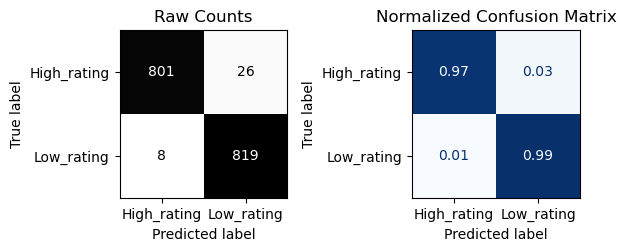


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.88      0.87      0.87       179
  Low_rating       0.87      0.88      0.88       184

    accuracy                           0.87       363
   macro avg       0.87      0.87      0.87       363
weighted avg       0.87      0.87      0.87       363



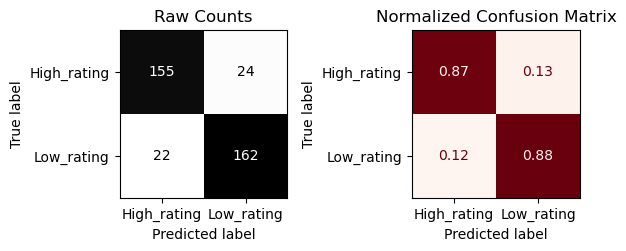

In [21]:
# Evaluate count_pipe
fn.evaluate_classification(count_pipe, X_train, y_train, X_test, y_test)

In [22]:
# Instantiate TF-IDF Vectorizor
tfidf = fn.TfidfVectorizer()

## Instantiate model
tfidfbayes = fn.MultinomialNB()


## Create pipeline: tfidf_pipe
tfidf_pipe = fn.Pipeline([('vectorizer', tfidf),
                       ('bayes', tfidfbayes)])



## Fit pipeline
tfidf_pipe.fit(X_train, y_train)
                      

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('bayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.98      0.97      0.98       827
  Low_rating       0.97      0.98      0.98       827

    accuracy                           0.98      1654
   macro avg       0.98      0.98      0.98      1654
weighted avg       0.98      0.98      0.98      1654



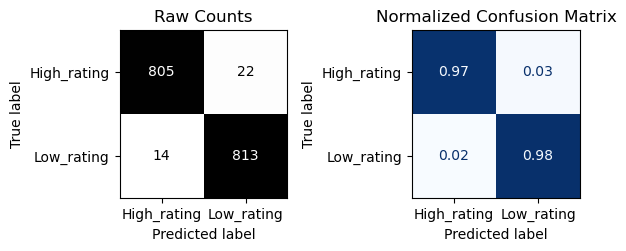


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.86      0.90      0.88       179
  Low_rating       0.90      0.86      0.88       184

    accuracy                           0.88       363
   macro avg       0.88      0.88      0.88       363
weighted avg       0.88      0.88      0.88       363



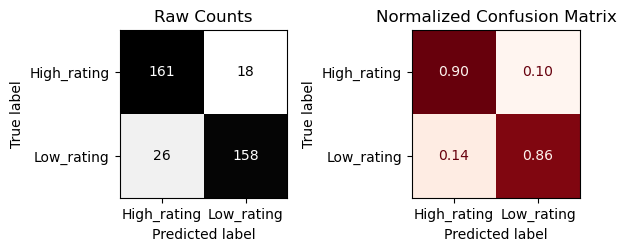

In [23]:
# Evaluate the tfidf_pipeline model
fn.evaluate_classification(tfidf_pipe, X_train, y_train, X_test, y_test)

## `Build a Machine Learning Model`
- Build a sklearn modeling pipeline with a text vectorizer and a classification model.
    - Suggested Models: MultinomialNB, LogisticRegression (you may need to increase max_iter), RandomForestClassifier
- Fit and evaluate the model using the machine learning classification models from sklearn.
    - In a Markdown cell, document your observations from your results. (e.g., how good is the model overall? Is it particularly good/bad at predicting one class?)

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_pipe  = fn.Pipeline([('vectorizer',fn.CountVectorizer()),
                    ('clf',fn.RandomForestClassifier(class_weight='balanced'))])
rf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('clf', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': RandomForestClassifier(class_weight='balanced'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_node

In [25]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[fn.CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [fn.TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']}]

In [26]:
%%time
# Create grid search
grid_search = fn.GridSearchCV(rf_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: total: 10.8 s
Wall time: 6min 31s


{'vectorizer': TfidfVectorizer(max_df=0.9, max_features=2000, min_df=2, stop_words='english',
                 use_idf=False),
 'vectorizer__max_df': 0.9,
 'vectorizer__max_features': 2000,
 'vectorizer__min_df': 2,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': 'english',
 'vectorizer__use_idf': False}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       1.00      1.00      1.00       827
  Low_rating       1.00      1.00      1.00       827

    accuracy                           1.00      1654
   macro avg       1.00      1.00      1.00      1654
weighted avg       1.00      1.00      1.00      1654



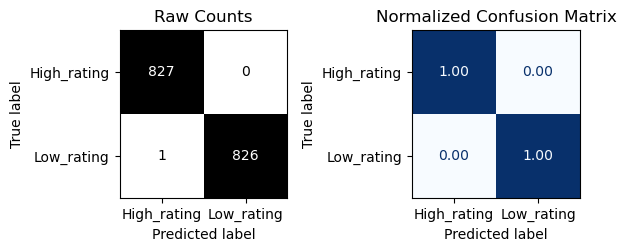


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.83      0.90      0.86       179
  Low_rating       0.89      0.82      0.86       184

    accuracy                           0.86       363
   macro avg       0.86      0.86      0.86       363
weighted avg       0.86      0.86      0.86       363



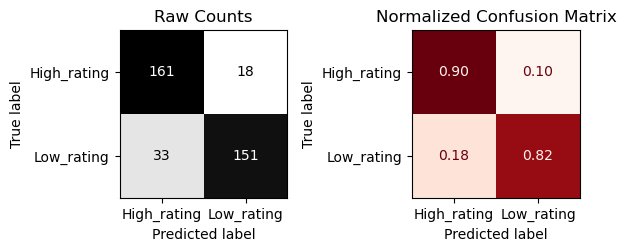

In [27]:
best_rf_pipe = grid_search.best_estimator_
fn.evaluate_classification(best_rf_pipe, X_train, y_train, X_test, y_test)

## `GridSearch Text Vectorization`
- Attempt to improve your model by tuning the text preprocessing steps.

### `Construct a grid of parameters for the text vectorization step. Consider trying:`
- CountVectorizer/TfidfVectorizer
- Stop Words
- ngram_range
- Min_df/max_df

In [28]:
gs_pipe = fn.Pipeline([('vectorizer',fn.CountVectorizer()),
                    ('clf',fn.MultinomialNB())])
gs_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [29]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[fn.CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [fn.TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']}]

### `Fit and evaluate the grid search results:`

In [30]:
%%time
# Create grid search
grid_search = fn.GridSearchCV(gs_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: total: 10 s
Wall time: 1min 43s


{'vectorizer': CountVectorizer(max_df=0.8, min_df=3),
 'vectorizer__max_df': 0.8,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.98      0.94      0.96       827
  Low_rating       0.94      0.98      0.96       827

    accuracy                           0.96      1654
   macro avg       0.96      0.96      0.96      1654
weighted avg       0.96      0.96      0.96      1654



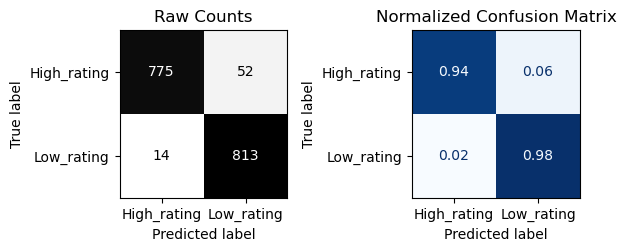


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

 High_rating       0.88      0.85      0.87       179
  Low_rating       0.86      0.89      0.88       184

    accuracy                           0.87       363
   macro avg       0.87      0.87      0.87       363
weighted avg       0.87      0.87      0.87       363



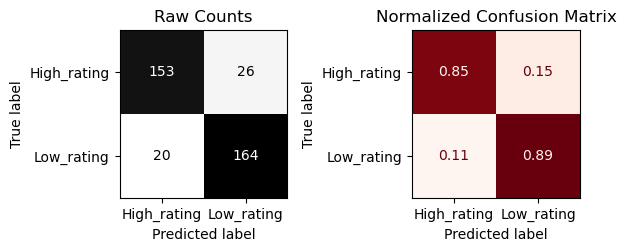

In [31]:
# Evaluate the best estimator
best_gs_pipe = grid_search.best_estimator_
fn.evaluate_classification(best_gs_pipe, X_train, y_train, X_test, y_test)

# <u>Deep NLP (RNNs):
- For this part of the project, you will use the a Keras TextVectorization layer as part of your RNN model.
- This serves the same purpose as using sklearn pipeline:
    - `It bundles text preparation into the model, making it deployment-ready.

In [32]:
df.head()

,original_title,review,rating,ratings,tokens,lemmatized,tokens-joined,lemmas-joined
movie_id,,,,,,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,High_rating,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,Low_rating,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0,Low_rating,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie,entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well h

#### Create train/test/val datasets:

In [33]:
# Define X and y
X = df['review']
y_string= df['ratings']
# Instantiate the LabelEncoder
encoder = fn.LabelEncoder()
# Fit and Transform the strings into integers
y = fn.pd.Series(encoder.fit_transform(y_string))
y.value_counts()

1    1224
0    1195
dtype: int64

In [34]:
# Convert to Dataset object
ds = fn.tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [35]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [36]:
# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")
# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")
# Test size is remainder
split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 1693 samples as training data
Use 483 samples as validation data
The remaining 243 samples will be used as test data.


In [37]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
# Take .take to slice out the correct number of samples for validation
val_ds = val_ds.take(n_val_samples)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples)

In [38]:
# Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [39]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 1
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 1693 training batches.
 There are 483 validation batches.
 There are 243 testing batches.


Inspecting the Data

In [40]:
# taking a sample 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)

tf.Tensor([b'We have yet another movie where it is getting high praise for reasons of politics...and possibly because Jamie Lee Curtis is back...but mainly for politics.\r\n\r\nBut it was really nice seeing Jamie Lee Curtis back, and nice in the "it doesn\'t really feel like a Halloween movie without her in it" kind of way.\r\n\r\nUnfortunately that isn\'t enough to save the film, nor is the added over-the-top blood and gore that didn\'t really need a place in the first two movies.\r\n\r\nBut...the blood and gore seemed to replace real scares (though there were a couple) as if to say, yeah, they understand that they aren\'t making this horror movie frightening, so they might as well make it bloodier and hope that it\'s a decent trade off for actual scares.\r\n\r\nThe main issue, however, is that it is spread thin. It\'s like it was written in committee where everyone that there little plot be added to the film despite how difficult that would make actual story telling.\r\n\r\nThe resul

In [41]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"A kid is getting other kids to play poker online. The head of the university doesn't like it and threaten to throw him out. The kid (Justin Timberlake) takes all his money and play some poker, hoping that he will win and his future secure. Well, you guessed it, he loses everything. But, not because he is bad or anything, no, there is this guy called Ivan (Ben Affleck) who runs these online casinos, and who cheats the poor young kids.\r\n\r\nNow there is only one sensible thing to do, which is to go to Costa Rica and confront the bad guy with his scheme. Thats exactly what I would do. Well, nah, not really, but I hope you see where I am going with this. He arrives in Costa Rica, and soon finds himself at the deep end of the pool, hunted by Ivan, some dude named Herrera and the FBI... of course.\r\n\r\nThe plot is idiotic, as you might have guessed. It makes no sense, and the poor actors don't know how to act. And honestly, I don't bl

#### Create a Keras Text Vectorization layer:

In [42]:
# Create the TextVectorization layer
count_vectorizer = fn.tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count"
)

In [43]:
# Before training, only contains the out of vocab token ([UNK])
count_vectorizer.get_vocabulary()

['[UNK]']

In [44]:
# Fit the layer on the training texts
count_vectorizer.adapt(ds_texts)

In [45]:
# Getting list of vocab
vocab = count_vectorizer.get_vocabulary()
# Exploring list of vocab
type(vocab), len(vocab), vocab[:6]

(list, 24922, ['[UNK]', 'the', 'and', 'a', 'of', 'to'])

In [46]:
# The first value will be the count of all of the words not in the vocobulary
counts= count_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
counts

<tf.Tensor: shape=(1, 24922), dtype=float32, numpy=array([[0., 2., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Build an RNN with the TextVectorization Layer:

In [47]:
# Create Text Vectorization Layer
tfidf_vectorizer = fn.tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="tf_idf",
)
# Build the vectorizer vocabulary
tfidf_vectorizer.adapt(ds_texts)
# Confrim vocabulary size
tfidf_vectorizer.vocabulary_size()

24922

In [48]:
# The first value will be the score of all of the words not in the vocobulary
tfidf = tfidf_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
tfidf

<tf.Tensor: shape=(1, 24922), dtype=float32, numpy=
array([[0.       , 1.4785116, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

Sequence Vectorizer

In [49]:
# Create text Vectorization layer
sequence_vectorizer = fn.tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=30
)
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

24923

In [50]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence = sequence_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
sequence

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[16469, 16469, 16469, 16469,     7,     2,    74,   392,   148,
            9,     2,   143,    16, 22305,   952,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int64)>

In [51]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'it',
 9: 'in',
 10: 'that',
 11: 'i',
 12: 'this',
 13: 'but',
 14: 'was',
 15: 'with',
 16: 'for',
 17: 'as',
 18: 'movie',
 19: 'film',
 20: 'not',
 21: 'are',
 22: 'its',
 23: 'on',
 24: 'be',
 25: 'you',
 26: 'one',
 27: 'have',
 28: 'his',
 29: 'an',
 30: 'so',
 31: 'all',
 32: 'like',
 33: 'from',
 34: 'he',
 35: 'at',
 36: 'by',
 37: 'just',
 38: 'they',
 39: 'if',
 40: 'about',
 41: 'or',
 42: 'what',
 43: 'more',
 44: 'story',
 45: 'has',
 46: 'there',
 47: 'some',
 48: 'even',
 49: 'who',
 50: 'my',
 51: 'good',
 52: 'really',
 53: 'me',
 54: 'out',
 55: 'very',
 56: 'time',
 57: 'when',
 58: 'no',
 59: 'which',
 60: 'we',
 61: 'only',
 62: 'well',
 63: 'their',
 64: 'had',
 65: 'much',
 66: 'can',
 67: 'up',
 68: 'than',
 69: 'would',
 70: 'also',
 71: 'because',
 72: 'great',
 73: 'way',
 74: 'most',
 75: 'do',
 76: 'into',
 77: 'her',
 78: 'characters',
 79: 'will',
 80: 'were',
 81: 'ho

In [52]:
# What term corresponds to 1000?
int_to_str[1000]

'whats'

In [53]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

24923

In [54]:
SEQUENCE_LENGTH = 30
SEQUENCE_LENGTH

30

In [55]:
# Define output dimension
EMBED_DIM = 150
EMBED_DIM

150

In [56]:
classes = y.unique()
classes

array([0, 1])

## Model 1: GRU

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model_stack_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = fn.tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [58]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = fn.tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

C:\Users\Valde\anaconda3\envs\dojo-env\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 30, 150)           3738450   
                                                                 
 gru_3 (GRU)                 (None, 30, 128)           107520    
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 30, 128)           99072     
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                      

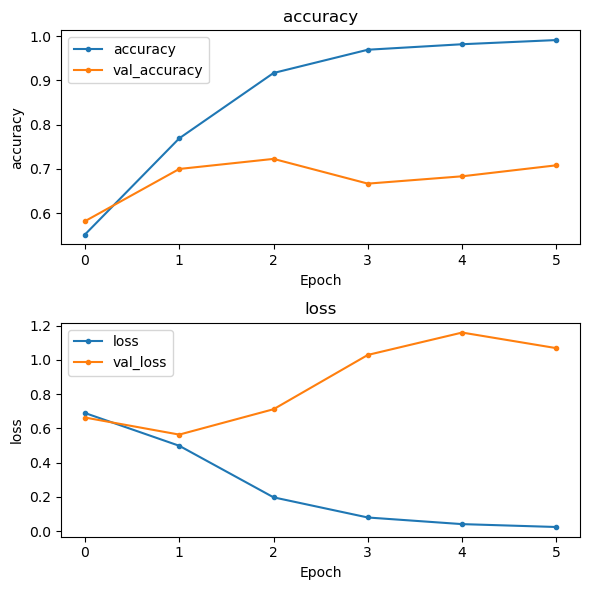


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       113
           1       0.71      0.75      0.73       130

    accuracy                           0.70       243
   macro avg       0.70      0.70      0.70       243
weighted avg       0.70      0.70      0.70       243



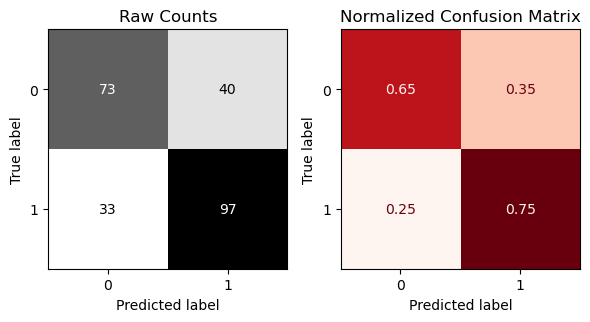


- Evaluating Test Data:
243/243 [==============================] - 2s 8ms/step - loss: 1.1200 - accuracy: 0.6996
{'loss': 1.1200251579284668, 'accuracy': 0.6995884776115417}


In [60]:
# Build model
model = build_gru_model_stack_deep_pool(sequence_vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = fn.evaluate_classification_network(
    model,
    X_test=test_ds, history=history
);

## Model 2: LSTM

In [61]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=150, #EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

In [62]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = fn.tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

C:\Users\Valde\anaconda3\envs\dojo-env\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 30, 150)           3738450   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3,881,556
Trainable params: 3,881,556
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1693/1693 [==============================] - 71s 41ms/step - loss: 0.7920 - accuracy: 0.4802 - val_

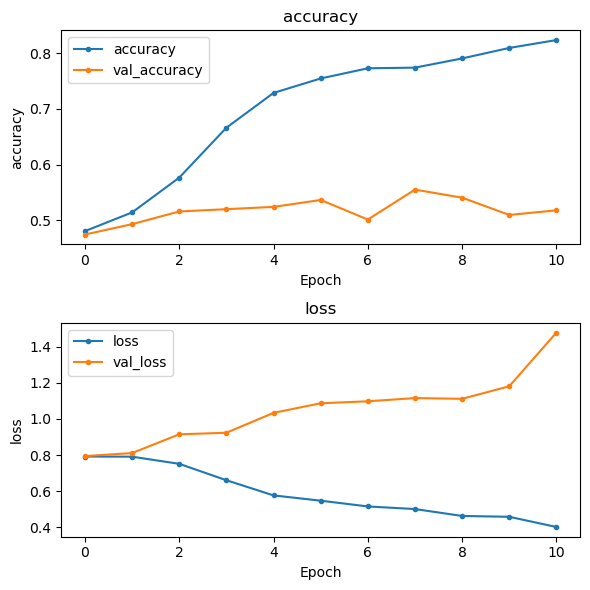


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       856
           1       0.93      0.65      0.77       837

    accuracy                           0.80      1693
   macro avg       0.84      0.80      0.80      1693
weighted avg       0.83      0.80      0.80      1693



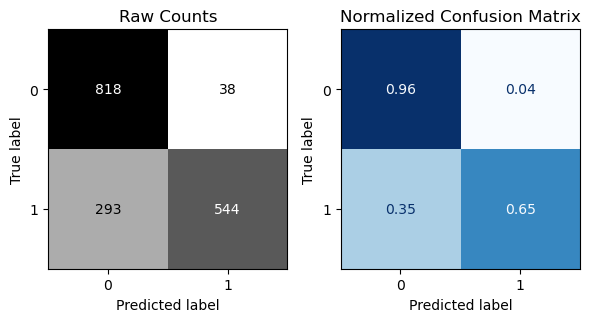


- Evaluating Training Data:
1693/1693 [==============================] - 6s 3ms/step - loss: 0.4495 - accuracy: 0.8045
{'loss': 0.4495042860507965, 'accuracy': 0.8044890761375427}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.73      0.57       113
           1       0.55      0.28      0.38       130

    accuracy                           0.49       243
   macro avg       0.51      0.51      0.48       243
weighted avg       0.51      0.49      0.47       243



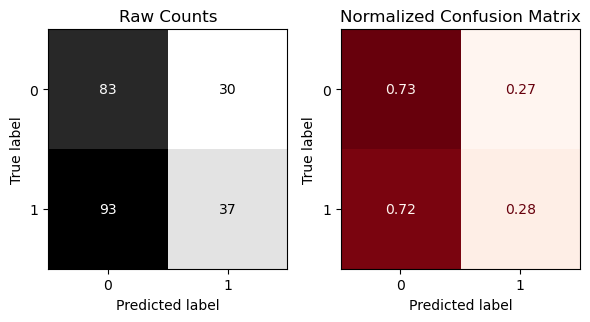


- Evaluating Test Data:
243/243 [==============================] - 1s 4ms/step - loss: 1.7156 - accuracy: 0.4938
{'loss': 1.7155916690826416, 'accuracy': 0.4938271641731262}


In [63]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Obtain the results
results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
);

## Model 3: Bi-Directional

In [64]:
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 24923
 EMBED_DIM: 150
 SEQUENCE_LENGTH: 30


In [65]:
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

In [66]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop =fn.tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

C:\Users\Valde\anaconda3\envs\dojo-env\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 30, 150)           3738450   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          215040    
 l)                                                              
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                      

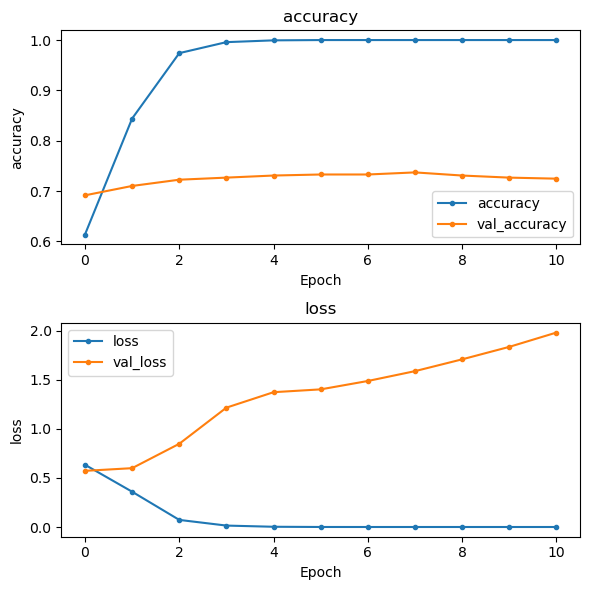


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      1.00      1.00       837

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



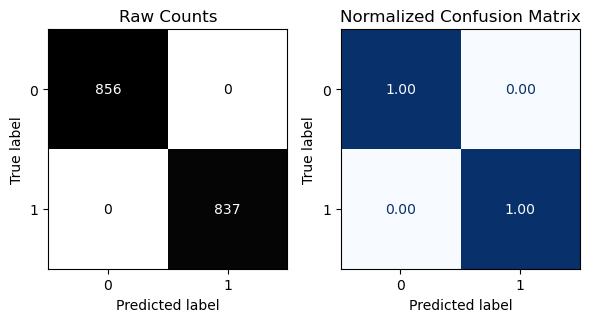


- Evaluating Training Data:
1693/1693 [==============================] - 7s 4ms/step - loss: 5.2634e-07 - accuracy: 1.0000
{'loss': 5.263359525997657e-07, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       113
           1       0.74      0.66      0.70       130

    accuracy                           0.69       243
   macro avg       0.69      0.69      0.69       243
weighted avg       0.70      0.69      0.69       243



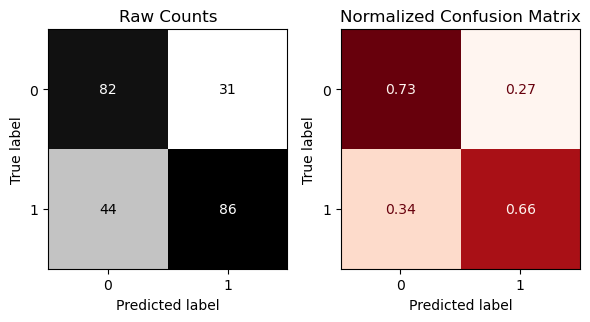


- Evaluating Test Data:
243/243 [==============================] - 1s 4ms/step - loss: 2.1243 - accuracy: 0.6914
{'loss': 2.1242728233337402, 'accuracy': 0.6913580298423767}


In [67]:
# Build the model
model = build_gru_model_bi_pool(sequence_vectorizer)

# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

# Project 2 Part 7: Saving

In [68]:
from pprint import pprint
FPATHS = dict(
    data={
        "raw": {
            "full": "Data-NLP/movie_reviews_v2.csv",  # (This is the original full dataframe we already have)
             "processed": "Data-NLP/processed_data.joblib" # We haven't saved this yet
        },
        "ml": {
            "train": "Data-NLP/training-data.joblib",  # (X_train,y_train) We haven't saved this yet
            "test": "Data-NLP/testing-data.joblib",  # (X_test,y_test) We haven't saved this yet
        },
    },
    models={
        "gru_model": "Models/gru.joblib", # We haven't saved this yet
        "random_forest": "models/random_forest/rf_reg.joblib", # We haven't saved this yet
    },
    images={
        "banner": "images/app-banner.png", # We haven't saved this yet
    },
)
pprint(FPATHS)

{'data': {'ml': {'test': 'Data-NLP/testing-data.joblib',
                 'train': 'Data-NLP/training-data.joblib'},
          'raw': {'full': 'Data-NLP/movie_reviews_v2.csv',
                  'processed': 'Data-NLP/processed_data.joblib'}},
 'images': {'banner': 'images/app-banner.png'},
 'models': {'gru_model': 'Models/gru.joblib',
            'random_forest': 'models/random_forest/rf_reg.joblib'}}


In [69]:
 ## Save the filepaths 
import os, json
os.makedirs('config/', exist_ok=True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

In [70]:
import os
def create_directories_from_paths(nested_dict):
    """OpenAI. (2023). ChatGPT [Large language model]. https://chat.openai.com 
    Recursively create directories for file paths in a nested dictionary.
    Parameters:
    nested_dict (dict): The nested dictionary containing file paths.
    """
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            # If the value is a dictionary, recurse into it
            create_directories_from_paths(value)
        elif isinstance(value, str):
            # If the value is a string, treat it as a file path and get the directory path
            directory_path = os.path.dirname(value)
            # If the directory path is not empty and the directory does not exist, create it
            if directory_path and not os.path.exists(directory_path):
                os.makedirs(directory_path)
                print(f"Directory created: {directory_path}")

# Use the function on your FPATHS dictionary
create_directories_from_paths(FPATHS)

In [71]:
# Open the file structure dictionary

import json
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)
FPATHS

{'data': {'raw': {'full': 'Data-NLP/movie_reviews_v2.csv',
   'processed': 'Data-NLP/processed_data.joblib'},
  'ml': {'train': 'Data-NLP/training-data.joblib',
   'test': 'Data-NLP/testing-data.joblib'}},
 'models': {'gru_model': 'Models/gru.joblib',
  'random_forest': 'models/random_forest/rf_reg.joblib'},
 'images': {'banner': 'images/app-banner.png'}}

In [72]:
# Define the filepath using the new dictionary structure
fpath = FPATHS['data']['raw']['full']
# Read in as normal
df_full = pd.read_csv(fpath)
df_full = df_full.set_index("movie_id")
df_full.head()

,original_title,review,rating
movie_id,,,
7443,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
955,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0
955,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,2.0
2621,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ag...",9.0
4234,Scream 3,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up...",4.0


In [73]:
import joblib
# Load training data with FPATHS dictionary
X_train, y_train = joblib.load(FPATHS['data']['ml']['train'])
X_train

array(["Easily the worst film I have ever seen that wasn't helmed by a female director. I am usually very picky when it comes to selecting movies to watch, hence my usually high satisfaction as a cinephile. I can't believe I wasted my time on this vile piece of garbage and that this ever saw a cinematic release when there MUST be thousands...NO, millions, of better things that could have been made instead. The Lumiere brothers must be rolling in their graves at how cinema has been travestied.\r\n\r\nMy only regret other than my time wasted and the scar on my brain from having watched it is the fact that unlike Metacritic, on themoviedb.org I can't give it a zero rating. Or a negative, for that matter! =)",
       "So Creeds kid as a good job and boxes on the side for reasons... and wins.\r\n\r\nBut he doesn't want to do underground boxing, he wasn't to make it big like his dad, because he's the bestest of the bestest.\r\n\r\nAnd there is a LITTLE struggle here, a little of the heros jo

In [74]:
# Defining the filepath for the training data using the dictionary
joblib_train_path = FPATHS['data']['ml']['train']
joblib_train_path

'Data-NLP/training-data.joblib'

In [75]:
# Saving x-train and y-train a file using path from the dictionary
joblib.dump([X_train, y_train], joblib_train_path)

['Data-NLP/training-data.joblib']

In [76]:
# Defining the filepath for the testing data using the dictionary
joblib_test_path = FPATHS['data']['ml']['test']
joblib_test_path

'Data-NLP/testing-data.joblib'

In [77]:
# Saving x-test and y-test in a file using path from the dictionary
joblib.dump([X_test, y_test], joblib_test_path)

['Data-NLP/testing-data.joblib']

In [78]:
# Now we can save our model using the filepath from the dictionary
rf_path = FPATHS['models']['random_forest']
rf_path

'models/random_forest/rf_reg.joblib'

In [79]:
# Save random forest model in a file using path from the dictionary
joblib.dump(best_rf_pipe, rf_path)

['models/random_forest/rf_reg.joblib']

### For your  Deep NLP model:

In [80]:
# Now we can save our model using the filepath from the dictionary
gru_model = FPATHS['models']['gru_model']
gru_model

'Models/gru.joblib'

In [81]:
fpath_model = "Models/gru.keras"
tf.keras.models.save_model(model, fpath_model)

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x00000159DDA75960>]

In [82]:
# Try to save NLP model as a .keras
try:
    fpath_model = "Models/gru.keras" 
    tf.keras.models.save_model(model, fpath_model)
except Exception as e:
    display(e)

NotImplementedError("Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x00000159DDA75960>]")

In [83]:
# Saving model in tf format 
fpath_model = "Models/gru/" # Filename is a folder 
tf.keras.models.save_model(model, fpath_model, save_format='tf')

INFO:tensorflow:Assets written to: Models/gru/assets


INFO:tensorflow:Assets written to: Models/gru/assets


In [84]:
# Viewing the file contents of the saved model
sorted(os.listdir(fpath_model))

['assets',
 'fingerprint.pb',
 'keras_metadata.pb',
 'saved_model.pb',
 'variables']

In [85]:
loaded_network = tf.keras.models.load_model(fpath_model)
loaded_network.summary()

C:\Users\Valde\anaconda3\envs\dojo-env\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 30, 150)           3738450   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          215040    
 l)                                                              
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                      


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       856
           1       1.00      1.00      1.00       837

    accuracy                           1.00      1693
   macro avg       1.00      1.00      1.00      1693
weighted avg       1.00      1.00      1.00      1693



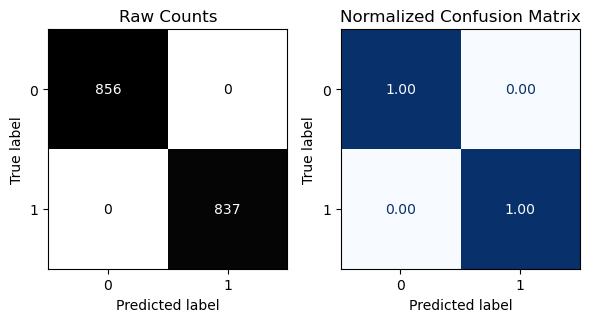


- Evaluating Training Data:
1693/1693 [==============================] - 6s 4ms/step - loss: 5.2634e-07 - accuracy: 1.0000
{'loss': 5.263358957563469e-07, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       113
           1       0.74      0.66      0.70       130

    accuracy                           0.69       243
   macro avg       0.69      0.69      0.69       243
weighted avg       0.70      0.69      0.69       243



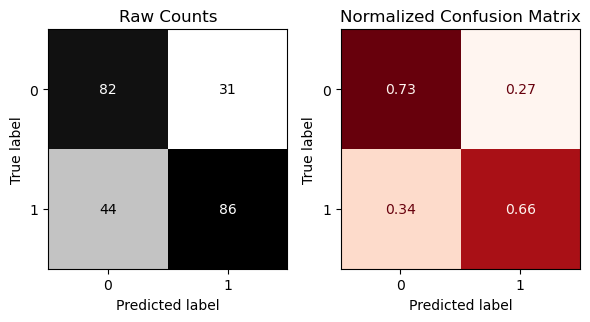


- Evaluating Test Data:
243/243 [==============================] - 1s 4ms/step - loss: 2.1243 - accuracy: 0.6914
{'loss': 2.1242728233337402, 'accuracy': 0.6913580298423767}


In [87]:
# Evaluate the model
results = fn.evaluate_classification_network(
    loaded_network, X_train=train_ds, 
    X_test=test_ds)

In [88]:
fpath_save_test_ds = "Data/tf/test/"
tf.data.Dataset.save(test_ds, fpath_save_test_ds)

In [89]:
test_ds = tf.data.Dataset.load(fpath_save_test_ds)

In [90]:
# Saving the training dataset
fpath_save_train_ds = "Data/tf/train/"
# train_ds.save(path=fpath_save_train_ds)
tf.data.Dataset.save(train_ds, fpath_save_train_ds)
# Saving the test dataset
fpath_save_test_ds = "Data/tf/test/"
# test_ds.save(path=fpath_save_test_ds)
tf.data.Dataset.save(test_ds, fpath_save_test_ds)

In [92]:
# Save model
model_fpath = FPATHS['models']['gru_model']
tf.keras.models.save_model(model, model_fpath, save_format='tf')

INFO:tensorflow:Assets written to: Models/gru.joblib\assets


INFO:tensorflow:Assets written to: Models/gru.joblib\assets
